## Reserve and configure resources on KVM

Before you run this experiment, you will:

-   define the specific configuration of resources you need.
-   “instantiate” an experiment with your reserved resources.
-   wait for your resources to be configured.
-   log in to resources to carry out the experiment.

This exercise will guide you through those steps.

### Configure environment

In [113]:
import openstack, chi, chi.ssh, chi.network, chi.server, os

In this section, we configure the Chameleon Python client.

For this experiment, we’re going to use the KVM@TACC site, which we indicate below.

We also need to specify the name of the Chameleon “project” that this experiment is part of. The project name will have the format “CHI-XXXXXX”, where the last part is a 6-digit number, and you can find it on your [user dashboard](https://chameleoncloud.org/user/dashboard/).

In the cell below, replace the project ID with your own project ID, then run the cell.

In [ ]:
chi.use_site("XXX")
PROJECT_NAME = "XXX"
chi.set("project_name", PROJECT_NAME)

# configure openstacksdk for actions unsupported by python-chi
os_conn = chi.clients.connection()


### Define configuration for this experiment (3 VMs)

For this specific experiment, we will need three virtual machines connected to a common network. Each of the virtual machines will be of the `m1.large` type, with 4 VCPUs, 8 GB memory, 40 GB disk space.

In [115]:
username = os.getenv('USER')

node_conf = [
 {'name': "node-0",  'flavor': 'm1.large', 'image': 'CC-Ubuntu20.04', 'packages': ["virtualenv"], 'bastion': True}, 
 {'name': "node-1",  'flavor': 'm1.large', 'image': 'CC-Ubuntu20.04', 'packages': [], 'bastion': False}, 
 {'name': "node-2",  'flavor': 'm1.large', 'image': 'CC-Ubuntu20.04', 'packages': [], 'bastion': False} 
]
net_conf = [
 {"name": "net0", "subnet": "192.168.1.0/24", "nodes": [{"name": "node-0",   "addr": "192.168.1.10"}, {"name": "node-1", "addr": "192.168.1.11"}, {"name": "node-2", "addr": "192.168.1.12"}]},
]
route_conf = []

### Configure resources

Now, we will prepare the VMs and network links that our experiment requires.

First, we will prepare a “public” network that we will use for SSH access to our VMs -

In [116]:
public_net = os_conn.network.create_network(name="public_net_" + username)
public_net_id = public_net.get("id")
public_subnet = os_conn.network.create_subnet(
    name="public_subnet_" + username,
    network_id=public_net.get("id"),
    ip_version='4',
    cidr="192.168.10.0/24",
    gateway_ip="192.168.10.1",
    is_dhcp_enabled = True
)

Next, we will prepare the “experiment” networks -

In [117]:
nets = []
net_ids = []
subnets = []
for n in net_conf:
    exp_net = os_conn.network.create_network(name="exp_" + n['name']  + '_' + username)
    exp_net_id = exp_net.get("id")
    os_conn.network.update_network(exp_net, is_port_security_enabled=False)
    exp_subnet = os_conn.network.create_subnet(
        name="exp_subnet_" + n['name']  + '_' + username,
        network_id=exp_net.get("id"),
        ip_version='4',
        cidr=n['subnet'],
        gateway_ip=None,
        is_dhcp_enabled = True
    )
    nets.append(exp_net)
    net_ids.append(exp_net_id)
    subnets.append(exp_subnet)

Now we create the VMs -

In [118]:
servers = []
server_ids = []
for i, n in enumerate(node_conf, start=10):
    image_uuid = os_conn.image.find_image(n['image']).id
    flavor_uuid = os_conn.compute.find_flavor(n['flavor']).id
    # find out details of exp interface(s)
    nics = [{'net-id': chi.network.get_network_id( "exp_" + net['name']  + '_' + username ), 'v4-fixed-ip': node['addr']} for net in net_conf for node in net['nodes'] if node['name']==n['name']]
    # also include a public network interface
    nics.insert(0, {"net-id": public_net_id, "v4-fixed-ip":"192.168.10." + str(i)})
    server = chi.server.create_server(
        server_name=n['name'] + "_" + username,
        image_id=image_uuid,
        flavor_id=flavor_uuid,
        nics=nics
    )
    servers.append(server)
    server_ids.append(chi.server.get_server(n['name'] + "_" + username).id)

We wait for all servers to come up before we proceed -

In [119]:
for server_id in server_ids:
    chi.server.wait_for_active(server_id)

Next, we will set up SSH access to the VMs.

First, we will make sure the “public” network is connected to the Internet. Then, we will configure it to permit SSH access on port 22 for each port connected to this network.

In [ ]:
# connect them to the Internet on the "public" network (e.g. for software installation)
router = chi.network.create_router('inet_router_' + username, gw_network_name='public')
chi.network.add_subnet_to_router(router.get("id"), public_subnet.get("id"))

In [121]:
# prepare SSH access on the servers that serve in "bastion" role
# WARNING: this relies on undocumented behavior of associate_floating_ip 
# that it associates the IP with the first port on the server
server_ips = []
for i, n in enumerate(node_conf):
    if 'bastion' in n and n['bastion']:
        ip = chi.server.associate_floating_ip(server_ids[i])
        server_ips.append(ip)

In [122]:
if not os_conn.get_security_group("Allow SSH"):
    os_conn.create_security_group("Allow SSH", "Enable SSH traffic on TCP port 22")
    os_conn.create_security_group_rule("Allow SSH", port_range_min=22, port_range_max=22, protocol='tcp', remote_ip_prefix='0.0.0.0/0')

security_group_id = os_conn.get_security_group("Allow SSH").id
for port in chi.network.list_ports(): 
    if port['port_security_enabled'] and port['network_id']==public_net.get("id"):
        os_conn.network.update_port(port['id'], security_groups=[security_group_id])

In [123]:
for ip in server_ips:
    chi.server.wait_for_tcp(ip, port=22)

The following cell may raise an error if some of your nodes are still getting set up! If that happens, wait a few minutes and try again. (And then a few minutes more, and try again, if it still raises an error.)

In [124]:
primary_remote = chi.ssh.Remote(server_ips[0])
physical_ips = [n['addr'] for n in net_conf[0]['nodes']]
server_remotes = [chi.ssh.Remote(physical_ip, gateway=primary_remote) for physical_ip in physical_ips]

Finally, we need to configure our resources, including software package installation and network configuration.

In [ ]:
import time
for i, n in enumerate(node_conf):
    remote = server_remotes[i]
    # enable forwarding
    remote.run(f"sudo sysctl -w net.ipv4.ip_forward=1") 
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=192.168.0.0/16 --permanent")
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=172.16.0.0/12 --permanent")
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=10.0.0.0/8 --permanent")
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=127.0.0.0/8 --permanent")
    # these are required for etcd
    remote.run(f"sudo firewall-cmd --zone=public --add-port=4001/tcp")
    remote.run(f"sudo firewall-cmd --zone=public --add-port=2379-2380/tcp")
    time.sleep(3)

In [ ]:
for i, n in enumerate(node_conf):
    # install packages
    if len(n['packages']):
            remote = server_remotes[i]
            remote.run(f"sudo apt update; sudo apt -y install " + " ".join(n['packages'])) 

In [127]:
# prepare a "hosts" file that has names and addresses of every node
hosts_txt = [ "%s\t%s" % ( n['addr'], n['name'] ) for net in net_conf  for n in net['nodes'] if type(n) is dict and n['addr']]
for remote in server_remotes:
    for h in hosts_txt:
        remote.run("echo %s | sudo tee -a /etc/hosts > /dev/null" % h)

In [128]:
# we also need to enable incoming traffic on the HTTP port
if not os_conn.get_security_group("Allow HTTP 32000"):
    os_conn.create_security_group("Allow HTTP 32000", "Enable HTTP traffic on TCP port 32000")
    os_conn.create_security_group_rule("Allow HTTP 32000", port_range_min=32000, port_range_max=32000, protocol='tcp', remote_ip_prefix='0.0.0.0/0')

# add existing security group
security_group_id = os_conn.get_security_group("Allow HTTP 32000").id
for port in chi.network.list_ports(): 
    if port['port_security_enabled'] and port['network_id']==public_net.get("id"):
        pri_security_groups = port['security_groups']
        pri_security_groups.append(security_group_id)
        os_conn.network.update_port(port['id'], security_groups=pri_security_groups)

### Draw the network topology

The following cells will draw the network topology, for your reference.

In [129]:
!pip install networkx

In [130]:
nodes = [ (n['name'], {'color': 'pink'}) for n in net_conf ] + [(n['name'], {'color': 'lightblue'}) for n in node_conf ]
edges = [(net['name'], node['name'], 
          {'label': node['addr'] + '/' + net['subnet'].split("/")[1] }) if node['addr'] else (net['name'], node['name']) for net in net_conf for node in net['nodes'] ]

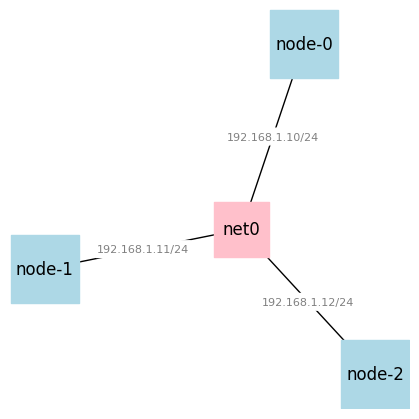

In [131]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(len(nodes),len(nodes)))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in nodes], 
        node_size=[len(n[0])*400 for n in nodes],  
        with_labels=True);
nx.draw_networkx_edge_labels(G,pos,
                             edge_labels=nx.get_edge_attributes(G,'label'),
                             font_color='gray',  font_size=8, rotate=False);

### Use Kubespray to prepare a Kubernetes cluster

Now that are resources are “up”, we will use Kubespray, a software utility for preparing and configuring a Kubernetes cluster, to set them up as a cluster.

In [132]:
remote = chi.ssh.Remote(server_ips[0])

In [ ]:
# install Python libraries required for Kubespray
remote.run("virtualenv -p python3 myenv")
remote.run("git clone --branch release-2.22 https://github.com/kubernetes-sigs/kubespray.git")
remote.run("source myenv/bin/activate; cd kubespray; pip3 install -r requirements.txt")

In [ ]:
# copy config files to correct locations
remote.run("mv kubespray/inventory/sample kubespray/inventory/mycluster")
remote.run("git clone https://github.com/teaching-on-testbeds/k8s.git")
remote.run("cp k8s/config/k8s-cluster.yml kubespray/inventory/mycluster/group_vars/k8s_cluster/k8s-cluster.yml")
remote.run("cp k8s/config/inventory.py    kubespray/contrib/inventory_builder/inventory.py")
remote.run("cp k8s/config/addons.yml      kubespray/inventory/mycluster/group_vars/k8s_cluster/addons.yml")

In [ ]:
# build inventory for this specific topology
physical_ips = [n['addr'] for n in net_conf[0]['nodes']]
physical_ips_str = " ".join(physical_ips)
remote.run(f"source myenv/bin/activate; declare -a IPS=({physical_ips_str});"+"cd kubespray; CONFIG_FILE=inventory/mycluster/hosts.yaml python3 contrib/inventory_builder/inventory.py ${IPS[@]}")


In [ ]:
# make sure "controller" node can SSH into the others
remote.run('ssh-keygen -t rsa -b 4096 -f ~/.ssh/id_rsa -q -N ""')
public_key = remote.run('cat ~/.ssh/id_rsa.pub').tail("stdout")[2:]

for physical_ip in physical_ips:
    remote_worker = chi.ssh.Remote(physical_ip, gateway=remote)
    remote_worker.run(f'echo {public_key} >> ~/.ssh/authorized_keys') 

The following cell will actually build the cluster. It will take a long time, and you may see many warnings in the output - that’s OK. The instructions below explain how to tell whether it was successful or not.

The output will be very long, so it will be truncated by default. When you see

    Output of this cell has been trimmed on the initial display.
    Displaying the first 50 top outputs.
    Click on this message to get the complete output.

at the end, click in order to see the rest of the output.

When the process is finished, you will see a “PLAY RECAP” in the output (near the end):

    PLAY RECAP *********************************************************************
    localhost                  : ok=3    changed=0    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   
    node-0                     : ok=752  changed=149  unreachable=0    failed=0    skipped=1276 rescued=0    ignored=8   
    node-1                     : ok=652  changed=136  unreachable=0    failed=0    skipped=1124 rescued=0    ignored=3   
    node-2                     : ok=535  changed=112  unreachable=0    failed=0    skipped=797  rescued=0    ignored=2   

Make sure that each node shows `failed=0`. If not, you should re-run the cell to re-try the failed parts.

In [ ]:
# build the cluster
remote.run("source myenv/bin/activate; cd kubespray; ansible-playbook -i inventory/mycluster/hosts.yaml  --become --become-user=root cluster.yml")

In [ ]:
# allow kubectl access for non-root user
remote.run("sudo cp -R /root/.kube /home/cc/.kube; sudo chown -R cc /home/cc/.kube; sudo chgrp -R cc /home/cc/.kube")

In [ ]:
# check installation
remote.run("kubectl get nodes")

### Set up Docker

Now that we have a Kubernetes cluster, we have a framework in place for container orchestration. But we still need to set up Docker, for building, sharing, and running those containers.

In [140]:
# add the user to the "docker" group on all hosts
for physical_ip in physical_ips:
    remote_worker = chi.ssh.Remote(physical_ip, gateway=remote)
    remote_worker.run("sudo groupadd -f docker; sudo usermod -aG docker $USER")

In [ ]:
# set up a private distribution registry on the "controller" node for distributing containers
# note: need a brand-new SSH session in order to "get" new group membership
remote = chi.ssh.Remote(server_ips[0])
remote.run("docker run -d -p 5000:5000 --restart always --name registry registry:2")

In [ ]:
# set up docker configuration on all the hosts
for physical_ip in physical_ips:
    remote_worker = chi.ssh.Remote(physical_ip, gateway=remote)
    remote_worker.run("sudo wget https://raw.githubusercontent.com/teaching-on-testbeds/k8s/main/config/daemon.json -O /etc/docker/daemon.json")
    remote_worker.run("sudo service docker restart")


In [ ]:
# check configuration
remote.run("docker run hello-world")

### Get SSH login details

At this point, we should be able to log in to our “controller” node over SSH! Run the following cell, and observe the output - you will see an SSH command this node.

In [ ]:
remote.run("ls")

In [145]:
print("ssh cc@" + server_ips[0])

ssh cc@129.114.27.201


Now, you can open an SSH session as follows:

-   In Jupyter, from the menu bar, use File \> New \> Terminal to open a new terminal.
-   Copy the SSH command from the output above, and paste it into the terminal.

Alternatively, you can use your local terminal to log on to each node, if you prefer. (On your local terminal, you may need to also specify your key path as part of the SSH command, using the `-i` argument followed by the path to your private key.)